In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np

from IPython.display import clear_output

## Load titanic dataset

In [2]:
train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
train_y = train_df.pop('survived')
eval_y = eval_df.pop('survived')

In [3]:
tf.random.set_seed(123)

## Create feature columns, input_fn, and the train the estimator

In [4]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_columns(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            key=feature_name, vocabulary_list=vocab
        )
    )

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocab = train_df[feature_name].unique()
    feature_columns.append(one_hot_cat_columns(feature_name, vocab))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [5]:
NUM_EXAMPLES = len(train_y)

def make_input_fn(X, y, num_epochs=None, shuffle=True):
    
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict('list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        
        # For training, cycle the through dataset as many times as need (n_epoch=None).
        dataset = dataset.repeat(num_epochs)
        # In memory training doesn't batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
        
    return input_fn

train_input_fn = make_input_fn(train_df, train_y)
eval_input_fn = make_input_fn(eval_df, eval_y, num_epochs=1, shuffle=False)

In [6]:
params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)
result = est.evaluate(eval_input_fn)
clear_output()
result

{'accuracy': 0.8030303,
 'accuracy_baseline': 0.625,
 'auc': 0.8646159,
 'auc_precision_recall': 0.8546749,
 'average_loss': 0.41861245,
 'label/mean': 0.375,
 'loss': 0.41861245,
 'precision': 0.7582418,
 'prediction/mean': 0.3824298,
 'recall': 0.6969697,
 'global_step': 100}

For performance reasons, when your data fits in memory, we recommend use the `boosted_trees_classifier_train_in_memory` function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the `tf.estimator.BoostedTrees` API shown above.

In [7]:
in_memory_params = dict(params)
in_memory_params.update({'n_batches_per_layer': 1})

In [13]:
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X: pd.DataFrame, y):
    y = np.expand_dims(y, axis=1)
    
    def input_fn():
        return X.to_dict('list'), y
    
    return input_fn

train_input_fn = make_inmemory_train_input_fn(train_df, train_y)

In [14]:
# Train the model
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    train_in_memory=True,
    **in_memory_params
)

est.train(input_fn=train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_pibjse_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [15]:
est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-19T06:43:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_pibjse_/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52638s
INFO:tensorflow:Finished evaluation at 2020-05-19-06:43:25
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.8616468, auc_precision_recall = 0.84852064, average_loss = 0.42089775, global_step = 153, label/mean = 0.375, loss = 0.42089775, precision = 0.75268817, prediction/mean = 0.38400736, recall = 0.7070707
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmp_pi

{'accuracy': 0.8030303,
 'accuracy_baseline': 0.625,
 'auc': 0.8616468,
 'auc_precision_recall': 0.84852064,
 'average_loss': 0.42089775,
 'label/mean': 0.375,
 'loss': 0.42089775,
 'precision': 0.75268817,
 'prediction/mean': 0.38400736,
 'recall': 0.7070707,
 'global_step': 153}

## Model interpretation and plotting

### Local interpretability

Refers to an understanding of a model's predictions at the individual example level.

Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in Palczewska et al and by Saabas in Interpreting Random Forests (this method is also available in scikit-learn for Random Forests in the treeinterpreter package). The DFCs are generated with:

In [16]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_pibjse_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [19]:
# Create DFC Pandas dataframe.
labels = eval_y.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.031307,0.092276,-0.177725,-0.081643,-0.063254,0.004970,0.483784
sex,264.0,0.004078,0.109364,-0.100808,-0.076052,-0.074326,0.138174,0.166265
class,264.0,0.017314,0.095392,-0.141641,-0.043370,-0.040795,0.031565,0.229792
deck,264.0,-0.016381,0.028724,-0.104268,-0.037882,-0.021543,0.001551,0.167450
fare,264.0,0.022904,0.090716,-0.208308,-0.034954,-0.012135,0.065481,0.245360
embark_town,264.0,-0.003470,0.031129,-0.051868,-0.010892,-0.009580,-0.003265,0.104475
n_siblings_spouses,264.0,0.002361,0.028554,-0.146794,0.002706,0.003291,0.006044,0.146853
parch,264.0,0.000743,0.006319,-0.068460,0.000242,0.000324,0.002251,0.024467
alone,264.0,0.000206,0.003676,-0.006822,0.000000,0.000000,0.000000,0.016494


A nice property of DFCs is that the sum of the contributions + the bias is equal to the prediction for a given example.

In [31]:
df_dfc.head()

,age,sex,class,deck,fare,embark_town,n_siblings_spouses,parch,alone
0,-0.078188,-0.076016,-0.043370,-0.037882,-0.023227,-0.010648,0.003223,0.000243,0.000000
1,-0.050353,-0.095041,0.036914,0.033175,-0.002667,-0.008453,0.006095,0.000461,0.014572
2,-0.074913,0.137652,0.229792,-0.004059,0.181584,-0.003973,0.002920,0.000220,0.007607
3,-0.127908,0.142745,0.222384,-0.005205,0.114560,-0.010020,0.004316,0.000332,0.000000
4,-0.052598,-0.084355,-0.055553,0.002418,-0.029389,-0.013411,0.004123,0.000311,0.000000


In [25]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(
    dfc_prob.values,
    probs.values
)

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8 # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(
        kind='barh',
        color=[colors],
        legend=None,
        alpha=0.75,
        figsize=(10,6)
    )
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # Add feature values.
    _add_feature_values(eval_df.iloc[ID][sorted_ix], ax)
    return ax

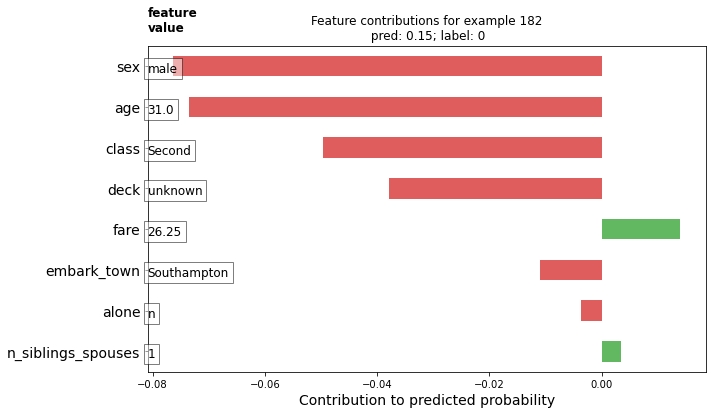

In [42]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

In [45]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
    # Initialize plot.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create example dataframe.
    TOP_N = 8  # View top 8 features.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # Add contributions of entire distribution.
    parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # Add feature values.
    _add_feature_values(eval_df.iloc[ID][sorted_ix], ax)

    # Add local contributions.
    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

    # Legend
    # Proxy plot, to show violinplot dist on legend.
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
    legend.get_frame().set_facecolor('white')

    # Format plot.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

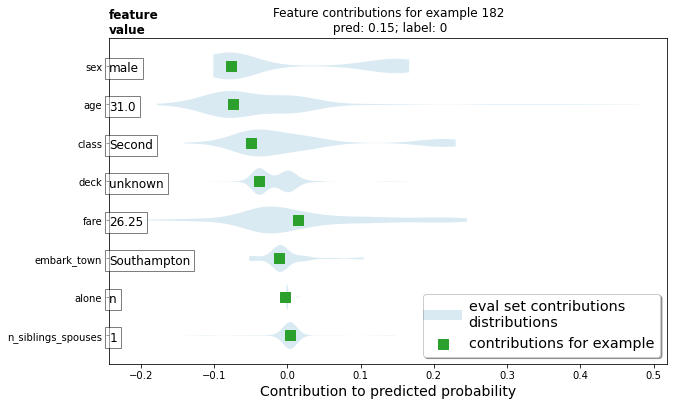

In [46]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

### Gloabl interpretability

Refers to an understanding of the model's as a whole.


Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:
- Gain-based feature importances using est.experimental_feature_importances
- Permutation importances
- Aggregate DFCs using est.experimental_predict_with_explanations

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

#### Gain-baseed feature importances

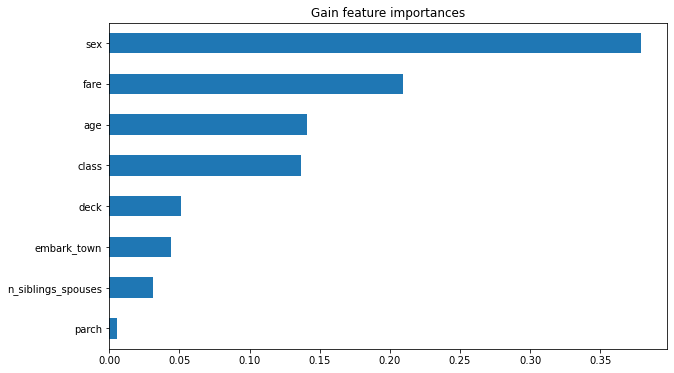

In [47]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

N = 8
ax = (df_imp.iloc[0: N][::-1]
      .plot(
          kind='barh',
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

#### Average absolute DFCs

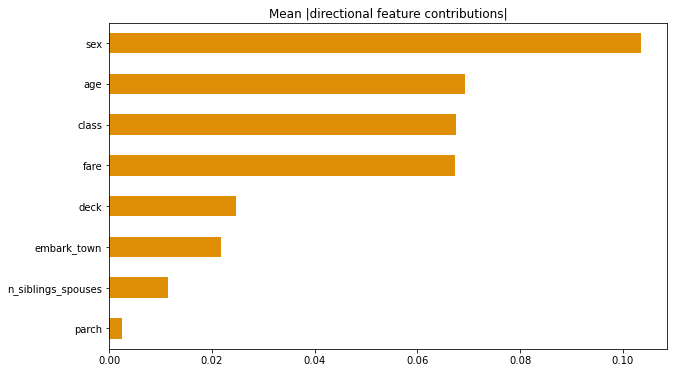

In [62]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

You can also see how DFCs vary as feature value varies.

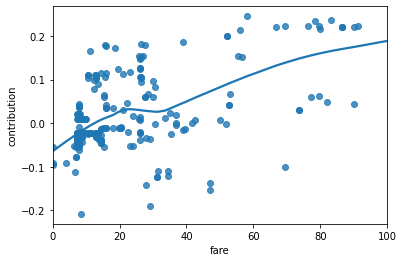

In [66]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=eval_df[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

#### Permutation feature importance

In [71]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    
    return np.array(imp)

def accuracy_metric(est, X, y):
    """Tensorflow estimator accuracy"""
    eval_input_fn = make_input_fn(X, y, shuffle=False, num_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, eval_df, eval_y, accuracy_metric, features)

clear_output()

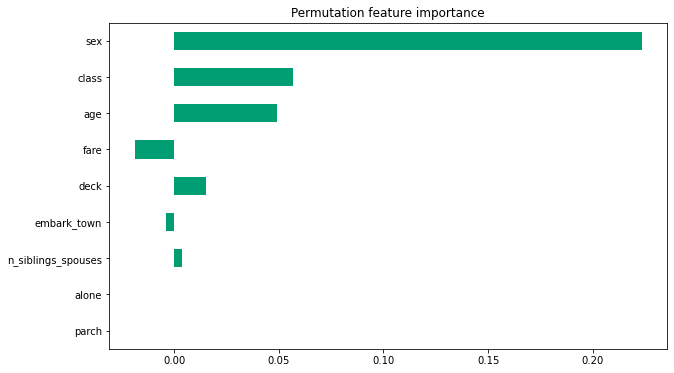

In [73]:
df_imp = pd.Series(importances, index=features)
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

## Visualizaing model fitting

In [82]:
# Generate pseudo dataset
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

In [80]:
def plot_contour(x, y, z, **kwargs):
    # Grid the data.
    plt.figure(figsize=(10, 8))
    # Contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
    plt.colorbar()  # Draw colorbar.
    # Plot data points.
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

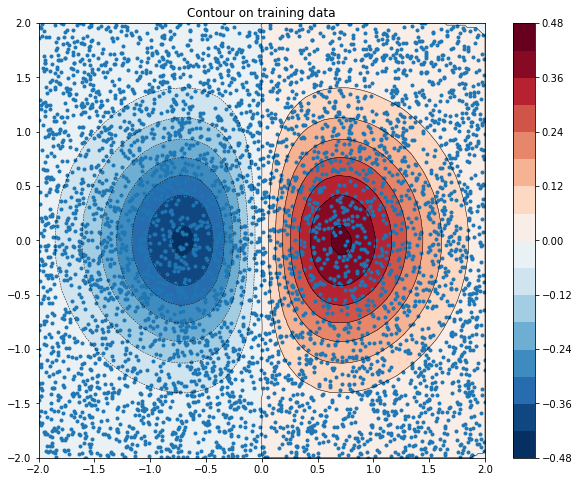

In [86]:
xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [87]:
feature_columns = [tf.feature_column.numeric_column('x'), tf.feature_column.numeric_column('y')]

In [129]:
df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

def predict(est):
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(df_predict.to_dict('list'))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

In [130]:
# Use simple LinearRegressor
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(feature_columns)
est.train(train_input_fn, max_steps=500);
clear_output()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplu6q0vl4/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


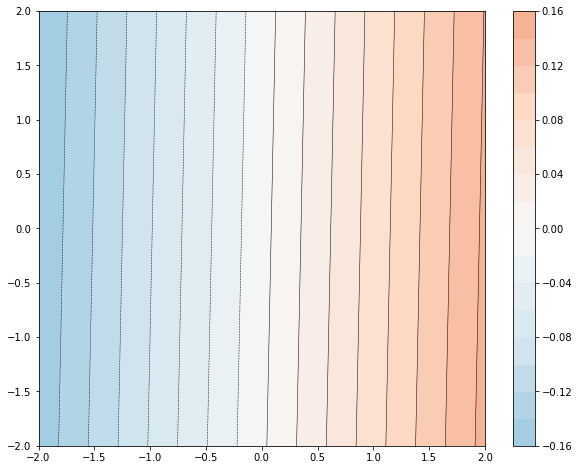

In [131]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsg_v3jdr/model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


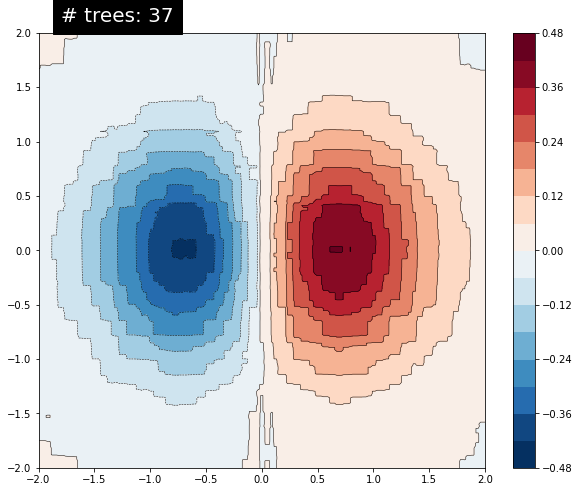

In [133]:
# use BoostedTreesRegressor
n_trees = 37 

est = tf.estimator.BoostedTreesRegressor(feature_columns, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()